# WORD2VEC MODEL

In [ ]:
### install packages for word embedding
pip install gensim==3.8.1 --user
pip install nltk --user

### install packages for ANN

!pip install --upgrade pip --user
!pip install conda install tensorflow --user
!pip install conda install keras
!pip install imblearn --user
!pip install scikit-learn==0.24.1 --user
!pip install --upgrade scikit-learn --user

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# adidas dataset Word2Vec model

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ndhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


maximun length of the sentence present in the document 1934
shape of matrix is: (4157, 300)
no of skipped words: 31
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1934, 300)         1247100   
_________________________________________________________________
flatten (Flatten)            (None, 580200)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1740603   
Total params: 2,987,703
Trainable params: 1,740,603
Non-trainable params: 1,247,100
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
13/13 [==============================] - 24s 1s/step - loss: 1.0434 - accuracy: 0.5886 - val_loss: 1.0

<IPython.core.display.Javascript object>


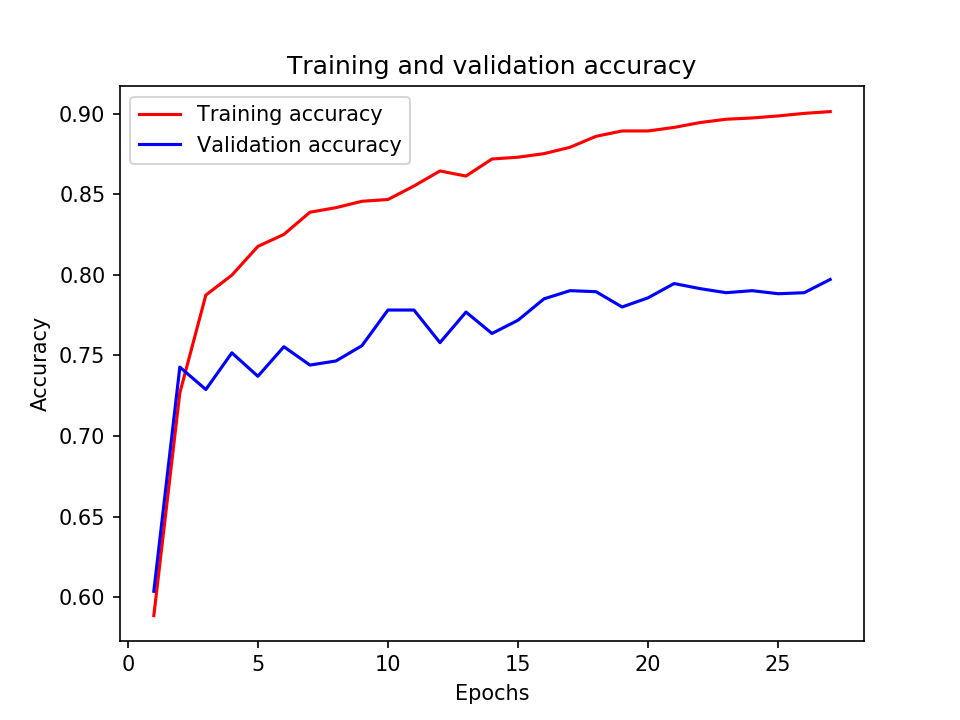

62/62 [==============================] - 2s 37ms/step - loss: 0.6502 - accuracy: 0.8008
test accuracy: 0.8008089065551758
[[  37   43   62]
 [  37   64   44]
 [ 125   83 1483]]
              precision    recall  f1-score   support

           0      0.186     0.261     0.217       142
           1      0.337     0.441     0.382       145
           2      0.933     0.877     0.904      1691

    accuracy                          0.801      1978
   macro avg      0.485     0.526     0.501      1978
weighted avg      0.836     0.801     0.817      1978



In [4]:
## importing the necessary library 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

### reading the data as dataframe
df = pd.read_excel('shoes.xlsx',sheet_name="Sheet2")

### deleting the unwanted column
del(df["marketplace"])
del(df["customer_id"])
del(df["review_id"])
del(df["product_parent"])
del(df["vine"])
del(df["review_headline"])
del(df["total_votes"])
del(df["product_category"])

#### create a brand subset
df['product_title']=df['product_title'].apply(lambda x: x.lower())

conditions =[(df['product_title'].str.contains('adidas')),
            (df['product_title'].str.contains('crocs')),
            (df['product_title'].str.contains('skechers'))]
values=['adidas','crocs','skechers']
df['Brand']=np.select(conditions,values)


#### labeling the data using star rating
df["verified_purchase"]=df.verified_purchase.map({'Y':1,'N':0})
df["positivity"] = df["star_rating"].apply(lambda x: 2 if x>3 else(0 if x==3 else 1))

### #Text Cleaning
# 1.1 Define preprocess function
df["review_body"] = df["review_body"].astype("str")
import string
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["i've","i'm",'on','ie','thesefor','im']
stopwords.extend(new_stopwords)
import re
wn=nltk.WordNetLemmatizer()


def removing_punc(ele):
    # Convert the text into lowercase
    ele = ele.lower()
    #punctuation
    ele = re.sub('[%s]' % re.escape(string.punctuation), '', ele)
    # number
    ele = re.sub(r'[0-9]', '', ele)
    #new line
    ele = re.sub('\n', '', ele)
    #white space
    ele= re.sub("^\s+", "", ele)
    return ele
df["review_body"]=df["review_body"].apply(lambda x: removing_punc(x))


def tokenize(txt):
    """tokenize each word by using split() function"""
    tokens=re.split('\W+', txt)
    return tokens
df['tokenized_message']=df['review_body'].apply(lambda x: tokenize(x))

def clean_word(txt_tokenized):
    """removed the stopword and remove the numbers and get the base word using lemmatize function"""
    new_word = [word for word in txt_tokenized if word not in stopwords]
    new_word = [word for word in new_word if word.isalpha()]
    new_word = [word for word in new_word if word in words]
    new_word = [wn.lemmatize(word) for word in new_word]
    return " ".join(new_word)
    
df['st_cleaned_message']=df['tokenized_message'].apply(lambda x:clean_word(x))


### extracting only the adidas shoe brand reviews from the dataset
adidas = df[df["Brand"]=="adidas"].sort_values(by=["review_date"], ascending=False)

### Removing unwanted column
del(adidas['product_id'])
del(adidas['product_title'])
#del(adidas['review_body'])
del(adidas['review_date'])
del(adidas['Brand'])

## define x and y variable
x=adidas['st_cleaned_message']
y=np.array(adidas['positivity'])

## tokenization
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(x)

## convert text to sequence
sequence = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

### finding the max length of the sentence present in the document
c=[]
for i in adidas['st_cleaned_message']:
    c.append(len(i))
max_length = max(c)
print('maximun length of the sentence present in the document',max_length)

### padding the sequence to equal length by post padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_reviews = pad_sequences(sequence, maxlen=max_length, padding='post')

### converting the vector to matrix of shape (4157,300)
unique_words = len(word_index)
total_words = unique_words +1
no_of_skipwords = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
    except:
        no_of_skipwords = no_of_skipwords + 1
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print('shape of matrix is:',embedding_matrix.shape)
print('no of skipped words:',no_of_skipwords)

## define data as independent variable
data = padded_reviews
from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(y)

## split the dataset as train and test for evalution
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.20, random_state = 42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import keras
from keras.callbacks import EarlyStopping
import warnings


embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix],input_length=max_length,trainable = False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
model.summary()


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 5 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience=10, 
                                       restore_best_weights=True) 
    
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(adidas['positivity']),
                                             adidas['positivity']))

weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
    
# model fit 
history = model.fit(x_train,
                        y_train,
                        callbacks=[es],
                        class_weight=weights,
                        epochs=100, 
                        batch_size=500,
                        shuffle=True,
                        validation_split=0.20,
                        verbose=1)
    
history_dict = history.history
# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
   
## new data come how the model predict 
y_test_pred = model.predict_classes(x_test)

loss, accuracy = model.evaluate(x_test, y_test)
print('test accuracy:',accuracy)

from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y_pred = np_utils.to_categorical(y_test_pred)

### classification report and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1))
print(matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1),dummy_y_pred.argmax(axis=1), digits=3))

In [100]:
### prediction output for adidas dataset
y_test
df = pd.DataFrame(y_test)
df['Actual'] = df.cumsum(axis=1).ne(1).sum(axis=1)
actual = df['Actual']
data = {'Actual': actual,'predicted':y_test_pred}
adidas_df = pd.DataFrame(data)
adidas_df
adidas_df.to_csv("adidas_prediction.csv",index=False)

# Skechers Dataset Word2Vec model

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ndhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


maximun length of the sentence present in the document 2214
shape of matrix is: (4801, 300)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2214, 300)         1440300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 664200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1992603   
Total params: 3,432,903
Trainable params: 1,992,603
Non-trainable params: 1,440,300
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 25s 1s/step - loss: 1.0286 - accuracy: 0.6057 - val_loss: 0.9227 - val_accuracy: 0.6692
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.8683 - accuracy: 0.7506 - val_loss: 0.8368 - val_accuracy:

<IPython.core.display.Javascript object>


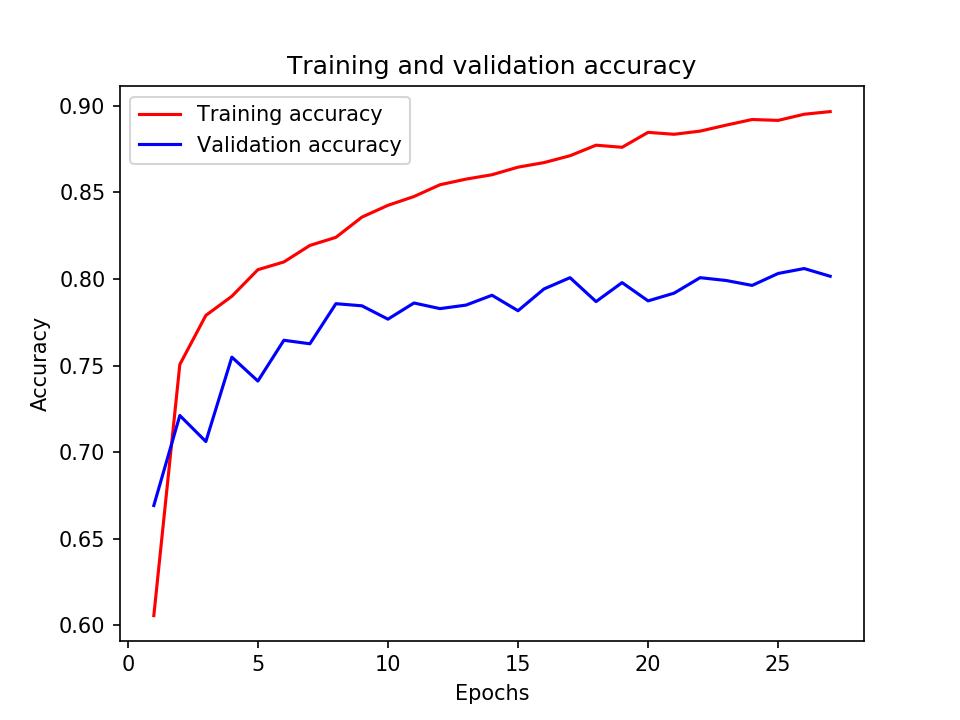

97/97 [==============================] - 4s 37ms/step - loss: 0.6203 - accuracy: 0.7925
test accuracy: 0.7925324440002441
[[  65   57  113]
 [  38  109   60]
 [ 197  174 2267]]
              precision    recall  f1-score   support

           0      0.217     0.277     0.243       235
           1      0.321     0.527     0.399       207
           2      0.929     0.859     0.893      2638

    accuracy                          0.793      3080
   macro avg      0.489     0.554     0.511      3080
weighted avg      0.834     0.793     0.810      3080



In [101]:
## importing the necessary library 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

### reading the data as dataframe
df = pd.read_excel('shoes.xlsx',sheet_name="Sheet2")

### deleting the unwanted column
del(df["marketplace"])
del(df["customer_id"])
del(df["review_id"])
del(df["product_parent"])
del(df["vine"])
del(df["review_headline"])
del(df["total_votes"])
del(df["product_category"])

#### create a brand subset
df['product_title']=df['product_title'].apply(lambda x: x.lower())

conditions =[(df['product_title'].str.contains('adidas')),
            (df['product_title'].str.contains('crocs')),
            (df['product_title'].str.contains('skechers'))]
values=['adidas','crocs','skechers']
df['Brand']=np.select(conditions,values)


#### labeling the data using star rating
df["verified_purchase"]=df.verified_purchase.map({'Y':1,'N':0})
df["positivity"] = df["star_rating"].apply(lambda x: 2 if x>3 else(0 if x==3 else 1))

### #Text Cleaning
# 1.1 Define preprocess function
df["review_body"] = df["review_body"].astype("str")
import string
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["i've","i'm",'on','ie','thesefor','im']
stopwords.extend(new_stopwords)
import re
wn=nltk.WordNetLemmatizer()


def removing_punc(ele):
    # Convert the text into lowercase
    ele = ele.lower()
    #punctuation
    ele = re.sub('[%s]' % re.escape(string.punctuation), '', ele)
    # number
    ele = re.sub(r'[0-9]', '', ele)
    #new line
    ele = re.sub('\n', '', ele)
    #white space
    ele= re.sub("^\s+", "", ele)
    return ele
df["review_body"]=df["review_body"].apply(lambda x: removing_punc(x))


def tokenize(txt):
    """tokenize each word by using split() function"""
    tokens=re.split('\W+', txt)
    return tokens
df['tokenized_message']=df['review_body'].apply(lambda x: tokenize(x))

def clean_word(txt_tokenized):
    """removed the stopword and remove the numbers and get the base word using lemmatize function"""
    new_word = [word for word in txt_tokenized if word not in stopwords]
    new_word = [word for word in new_word if word.isalpha()]
    new_word = [word for word in new_word if word in words]
    new_word = [wn.lemmatize(word) for word in new_word]
    return " ".join(new_word)
    
df['st_cleaned_message']=df['tokenized_message'].apply(lambda x:clean_word(x))


### extracting only the adidas shoe brand reviews from the dataset
skechers = df[df["Brand"]=="skechers"].sort_values(by=["review_date"], ascending=False)

### Removing unwanted column
del(skechers['product_id'])
del(skechers['product_title'])
#del(skechers['review_body'])
del(skechers['review_date'])
del(skechers['Brand'])

## define x and y variable
x=skechers['st_cleaned_message']
y=np.array(skechers['positivity'])

## tokenization
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(x)

## convert text to sequence
sequence = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

### finding the max length of the sentence present in the document
c=[]
for i in skechers['st_cleaned_message']:
    c.append(len(i))
max_length = max(c)
print('maximun length of the sentence present in the document',max_length)

### padding the sequence to equal length by post padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_reviews = pad_sequences(sequence, maxlen=max_length, padding='post')

### converting the vector to matrix of shape (4801,300)
unique_words = len(word_index)
total_words = unique_words +1
no_of_skipwords = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
    except:
        no_of_skipwords = no_of_skipwords + 1
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print('shape of matrix is:',embedding_matrix.shape)

## define data as independent variable
data = padded_reviews
from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(y)

## split the dataset as train and test for evalution
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.20, random_state = 42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import keras
from keras.callbacks import EarlyStopping
import warnings


embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix],input_length=max_length,trainable = False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
model.summary()


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 5 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience=10, 
                                       restore_best_weights=True) 
    
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(skechers['positivity']),
                                             skechers['positivity']))

weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
    
# model fit 
history = model.fit(x_train,
                        y_train,
                        callbacks=[es],
                        class_weight=weights,
                        epochs=100, 
                        batch_size=500,
                        shuffle=True,
                        validation_split=0.20,
                        verbose=1)
    
history_dict = history.history
# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
   
## new data come how the model predict 
y_test_pred1 = model.predict_classes(x_test)

loss, accuracy = model.evaluate(x_test, y_test)
print('test accuracy:',accuracy)

from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y_pred = np_utils.to_categorical(y_test_pred1)

### classification report and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1))
print(matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1),dummy_y_pred.argmax(axis=1), digits=3))

In [102]:
### prediction output for Skechers dataset
y_test
df = pd.DataFrame(y_test)
df['Actual'] = df.cumsum(axis=1).ne(1).sum(axis=1)
actual = df['Actual']
data = {'Actual': actual,'predicted':y_test_pred1}
skechers_df = pd.DataFrame(data)
skechers_df
skechers_df.to_csv("skechers_prediction.csv",index=False)

# Crocs Brand shoes Dataset Word2Vec model

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ndhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


maximun length of the sentence present in the document 1407
shape of matrix is: (5033, 300)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1407, 300)         1509900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 422100)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1266303   
Total params: 2,776,203
Trainable params: 1,266,303
Non-trainable params: 1,509,900
_________________________________________________________________
Epoch 1/100
21/21 [==============================] - 14s 656ms/step - loss: 1.0343 - accuracy: 0.5961 - val_loss: 0.9437 - val_accuracy: 0.6676
Epoch 2/100
21/21 [==============================] - 13s 605ms/step - loss: 0.8793 - accuracy: 0.7459 - val_loss: 0.8460 - val_acc

<IPython.core.display.Javascript object>


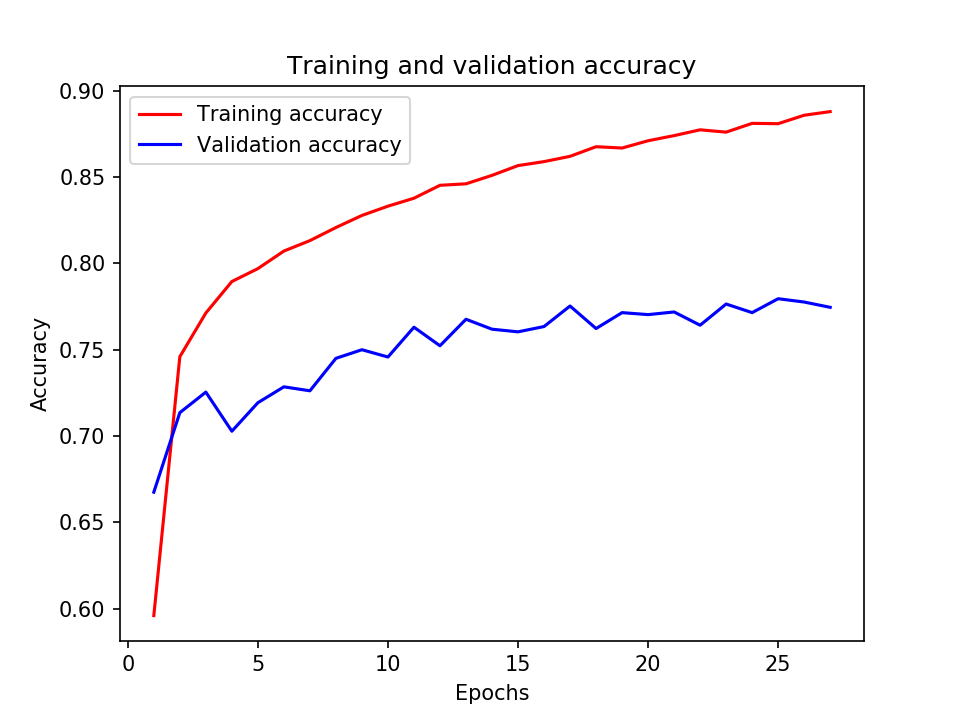

102/102 [==============================] - 3s 28ms/step - loss: 0.6770 - accuracy: 0.7718
test accuracy: 0.7717791199684143
[[  98   76  114]
 [  54  173   73]
 [ 232  195 2245]]
              precision    recall  f1-score   support

           0      0.255     0.340     0.292       288
           1      0.390     0.577     0.465       300
           2      0.923     0.840     0.880      2672

    accuracy                          0.772      3260
   macro avg      0.523     0.586     0.545      3260
weighted avg      0.815     0.772     0.790      3260



In [103]:
## importing the necessary library 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

### reading the data as dataframe
df = pd.read_excel('shoes.xlsx',sheet_name="Sheet2")

### deleting the unwanted column
del(df["marketplace"])
del(df["customer_id"])
del(df["review_id"])
del(df["product_parent"])
del(df["vine"])
del(df["review_headline"])
del(df["total_votes"])
del(df["product_category"])

#### create a brand subset
df['product_title']=df['product_title'].apply(lambda x: x.lower())

conditions =[(df['product_title'].str.contains('adidas')),
            (df['product_title'].str.contains('crocs')),
            (df['product_title'].str.contains('skechers'))]
values=['adidas','crocs','skechers']
df['Brand']=np.select(conditions,values)


#### labeling the data using star rating
df["verified_purchase"]=df.verified_purchase.map({'Y':1,'N':0})
df["positivity"] = df["star_rating"].apply(lambda x: 2 if x>3 else(0 if x==3 else 1))

### #Text Cleaning
# 1.1 Define preprocess function
df["review_body"] = df["review_body"].astype("str")
import string
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["i've","i'm",'on','ie','thesefor','im']
stopwords.extend(new_stopwords)
import re
wn=nltk.WordNetLemmatizer()


def removing_punc(ele):
    # Convert the text into lowercase
    ele = ele.lower()
    #punctuation
    ele = re.sub('[%s]' % re.escape(string.punctuation), '', ele)
    # number
    ele = re.sub(r'[0-9]', '', ele)
    #new line
    ele = re.sub('\n', '', ele)
    #white space
    ele= re.sub("^\s+", "", ele)
    return ele
df["review_body"]=df["review_body"].apply(lambda x: removing_punc(x))


def tokenize(txt):
    """tokenize each word by using split() function"""
    tokens=re.split('\W+', txt)
    return tokens
df['tokenized_message']=df['review_body'].apply(lambda x: tokenize(x))

def clean_word(txt_tokenized):
    """removed the stopword and remove the numbers and get the base word using lemmatize function"""
    new_word = [word for word in txt_tokenized if word not in stopwords]
    new_word = [word for word in new_word if word.isalpha()]
    new_word = [word for word in new_word if word in words]
    new_word = [wn.lemmatize(word) for word in new_word]
    return " ".join(new_word)
    
df['st_cleaned_message']=df['tokenized_message'].apply(lambda x:clean_word(x))


### extracting only the adidas shoe brand reviews from the dataset
crocs = df[df["Brand"]=="crocs"].sort_values(by=["review_date"], ascending=False)

### Removing unwanted column
del(crocs['product_id'])
del(crocs['product_title'])
#del(crocs['review_body'])
del(crocs['review_date'])
del(crocs['Brand'])

## define x and y variable
x=crocs['st_cleaned_message']
y=np.array(crocs['positivity'])

## tokenization
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(x)

## convert text to sequence
sequence = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

### finding the max length of the sentence present in the document
c=[]
for i in crocs['st_cleaned_message']:
    c.append(len(i))
max_length = max(c)
print('maximun length of the sentence present in the document',max_length)

### padding the sequence to equal length by post padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_reviews = pad_sequences(sequence, maxlen=max_length, padding='post')

### converting the vector to matrix of shape (4157,300)
unique_words = len(word_index)
total_words = unique_words +1
no_of_skipwords = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
    except:
        no_of_skipwords = no_of_skipwords + 1
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print('shape of matrix is:',embedding_matrix.shape)

## define data as independent variable
data = padded_reviews
from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(y)

## split the dataset as train and test for evalution
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.20, random_state = 42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import keras
from keras.callbacks import EarlyStopping
import warnings


embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix],input_length=max_length,trainable = False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
model.summary()


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 5 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience=10, 
                                       restore_best_weights=True) 
    
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(crocs['positivity']),
                                             crocs['positivity']))

weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
    
# model fit 
history = model.fit(x_train,
                        y_train,
                        callbacks=[es],
                        class_weight=weights,
                        epochs=100, 
                        batch_size=500,
                        shuffle=True,
                        validation_split=0.20,
                        verbose=1)
    
history_dict = history.history
# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
   
## new data come how the model predict 
y_test_pred2 = model.predict_classes(x_test)

loss, accuracy = model.evaluate(x_test, y_test)
print('test accuracy:',accuracy)

from keras.utils import np_utils
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y_pred = np_utils.to_categorical(y_test_pred2)

### classification report and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1))
print(matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1),dummy_y_pred.argmax(axis=1), digits=3))

In [104]:
### prediction output for Skechers dataset
y_test
df = pd.DataFrame(y_test)
df['Actual'] = df.cumsum(axis=1).ne(1).sum(axis=1)
actual = df['Actual']
data = {'Actual': actual,'predicted':y_test_pred2}
crocs_df = pd.DataFrame(data)
crocs_df
crocs_df.to_csv("crocs_prediction.csv",index=False)